In [10]:
!pip install torchview
!pip install graphviz
!pip install torchsummary
!pip install pillow

In [11]:
import torch
from matplotlib import pyplot as plt
from PIL import Image

# all nn libraries nn.layer, convs and loss functions
import torch.nn as nn
from IPython.display import Image
import torchvision
from torchview import draw_graph
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
model_parameters = {}
model_parameters['resnet50'] = ([64, 128, 256, 512], [3, 4, 6, 3], 4)

In [13]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, intermediate_channels, expansion, stride):
        super(Bottleneck, self).__init__()
        self.expansion = expansion
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        # i.e. if dim(x) == dim(F) => Identity function
        if self.in_channels == self.intermediate_channels * self.expansion:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels * self.expansion,
                                                kernel_size=1, stride=stride, padding=0, bias=False))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels * self.expansion))
            # Only conv->BN and no ReLU
            # projection_layer.append(nn.ReLU())
            self.projection = nn.Sequential(*projection_layer)
        # commonly used relu
        self.relu = nn.ReLU()
        # bottleneck
        # 1x1
        self.conv1_1x1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)

        # 3x3
        self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels,
                                   kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

        # 1x1
        self.conv3_1x1 = nn.Conv2d(in_channels=self.intermediate_channels,
                                   out_channels=self.intermediate_channels * self.expansion, kernel_size=1, stride=1,
                                   padding=0, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.intermediate_channels * self.expansion)

    def forward(self, x):
        # input stored to be added before the final relu
        in_x = x
        x = self.relu(self.batchnorm1(self.conv1_1x1(x)))
        # conv3x3->BN->relu
        x = self.relu(self.batchnorm2(self.conv2_3x3(x)))
        # conv1x1->BN
        x = self.batchnorm3(self.conv3_1x1(x))
        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)
        # final relu
        x = self.relu(x)
        return x

In [14]:
class ResNet(nn.Module):
    def __init__(self, resnet_variant, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.channels_list = resnet_variant[0]
        self.repeatition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]

        # B1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # B2-B5
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block1 = self._make_blocks(64, self.channels_list[0], self.repeatition_list[0], self.expansion, stride=1)
        self.block2 = self._make_blocks(self.channels_list[0] * self.expansion, self.channels_list[1],
                                        self.repeatition_list[1], self.expansion, stride=2)
        self.block3 = self._make_blocks(self.channels_list[1] * self.expansion, self.channels_list[2],
                                        self.repeatition_list[2], self.expansion, stride=2)
        self.block4 = self._make_blocks(self.channels_list[2] * self.expansion, self.channels_list[3],
                                        self.repeatition_list[3], self.expansion, stride=2)
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3] * self.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.average_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x

    def _make_blocks(self, in_channels, intermediate_channels, num_repeat, expansion, stride):
        layers = []
        layers.append(Bottleneck(in_channels, intermediate_channels, expansion, stride=stride))
        for num in range(1, num_repeat):
            layers.append(Bottleneck(intermediate_channels * expansion, intermediate_channels, expansion, stride=1))
        return nn.Sequential(*layers)


In [15]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



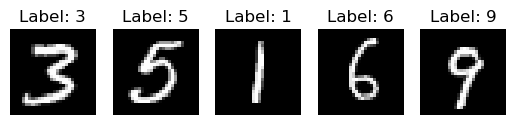

In [16]:

images, labels = next(iter(train_loader))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze() để loại bỏ chiều kênh nếu cần
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.show()

In [17]:
model = ResNet(model_parameters['resnet50'], in_channels=1, num_classes=10)
model.to(device)  # Di chuyển mô hình đến thiết bị (CPU hoặc GPU)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
# Huấn luyện mô hình
num_epochs = 10
best_accuracy = 0.0
patience = 2
epochs_no_improve = 0

best_model_path = 'best_model.pth'
if os.path.exists(best_model_path):
    # Load checkpoint nếu có
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded checkpoint from {best_model_path}")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    best_accuracy = 100 * correct / total
    print(f"Initial Validation Accuracy: {best_accuracy:.2f}%")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Đánh giá mô hình trên tập xác thực
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with accuracy {best_accuracy:.2f}% to {best_model_path}")
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1} after {patience} epochs with no improvement.")
        break 

Loaded checkpoint from best_model.pth


/tmp/ipykernel_9797/1523514783.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Initial Validation Accuracy: 99.67%
Epoch [1/10], Train Loss: 0.0183
Epoch [1/10], Validation Accuracy: 99.70%, Validation Loss: 0.0123
Saved best model with accuracy 99.70% to best_model.pth
Epoch [2/10], Train Loss: 0.0106
Epoch [2/10], Validation Accuracy: 99.70%, Validation Loss: 0.0129
Epoch [3/10], Train Loss: 0.0108
Epoch [3/10], Validation Accuracy: 99.59%, Validation Loss: 0.0172
Early stopping at epoch 3 after 2 epochs with no improvement.


In [19]:
model.eval()  # Chuyển sang chế độ evaluation
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}")

Test Accuracy: 99.16%, Test Loss: 0.0302


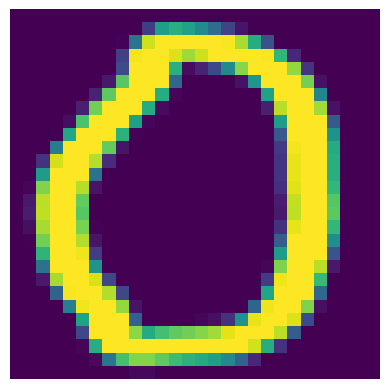

Lớp dự đoán: 0


/tmp/ipykernel_9797/1159784526.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [20]:
from PIL import Image

def predict(image_path):
    # Load and preprocess the image
    
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = Image.eval(image, lambda x: 255 - x)

    image = image.resize((28, 28))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    image = transform(image).unsqueeze(0)

    # Move tensor to the device
    image = image.to(device)

    # Make prediction
    model.load_state_dict(torch.load(best_model_path))
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_class = predicted.item()

    return predicted_class


# Example usage:

image_path = "0.png"
predicted_class = predict(image_path)
print(f"Lớp dự đoán: {predicted_class}")